In [37]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
from astroquery.mast import Catalogs
import pandas as pd
from tqdm import tqdm

%matplotlib inline

In [38]:
df = pd.read_csv("/Users/tsbarcl2/Downloads/csv-file-toi-catalog.csv", header=4)
usecols = [
    "TIC",
    "Full TOI ID",
    "TOI Disposition",
    "TIC Right Ascension",
    "TIC Declination",
    "TMag Value",
    "Orbital Epoch Value",
    "Orbital Period Value",
    "Transit Duration Value",
    "Transit Depth Value",
    "Sectors",
    "Public Comment",
    "Surface Gravity Value",
    "Signal ID",
    "Star Radius Value",
    "Planet Radius Value",
    "Planet Equilibrium Temperature (K) Value",
    "Effective Temperature Value",
    "Effective Stellar Flux Value",
    "Signal-to-noise",
]

df = df[usecols]

In [39]:
df.loc[:, "rprs"] = (
    df.loc[:, "Planet Radius Value"] / df.loc[:, "Star Radius Value"] * 0.0091577
)

In [40]:
bbp = blackbody_lambda(
    7.5 * u.um, df.loc[:, "Planet Equilibrium Temperature (K) Value"] * u.K
)
bbs = blackbody_lambda(7.5 * u.um, df.loc[:, "Effective Temperature Value"] * u.K)

/Users/tsbarcl2/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tsbarcl2/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [41]:
df.loc[:, "tempratio"] = 1.1 * bbp / bbs

In [131]:
kmag = np.array([])
jmag = np.array([])
for row in tqdm(df.itertuples(), total=df.shape[0]):
    catalog_data = Catalogs.query_object(
        "TIC {}".format(row.TIC), catalog="TIC", radius=0.1 * u.arcsec,
    )
    kmag = np.r_[kmag, catalog_data[0]["Kmag"]]
    jmag = np.r_[kmag, catalog_data[0]["Jmag"]]

100%|██████████| 1417/1417 [36:51<00:00,  1.34s/it] 


In [132]:
df.loc[:, "Kmag"] = kmag
df.loc[:, "ESM"] = (
    df.loc[:, "tempratio"]
    * df.loc[:, "rprs"] ** 2
    * 10 ** (-df.loc[:, "Kmag"] / 5)
    * 4.29e6
)

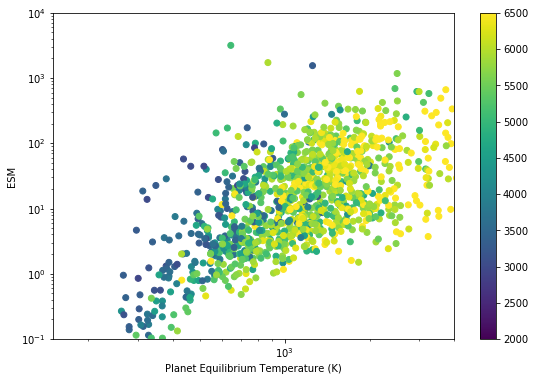

In [133]:
plt.figure(figsize=(9, 6))
plt.scatter(
    df.loc[:, "Planet Equilibrium Temperature (K) Value"],
    df.loc[:, "ESM"],
    c=df.loc[:, "Effective Temperature Value"],
    vmin=2000,
    vmax=6500,
)
plt.colorbar()
plt.yscale("log")
plt.xscale("log")


plt.xlim(150, 4000)
plt.ylim(0.1, 10000)

plt.ylabel("ESM")
plt.xlabel("Planet Equilibrium Temperature (K)")

plt.savefig("ESM-TESS-candidates-12052019-barclay.png", dpi=200)

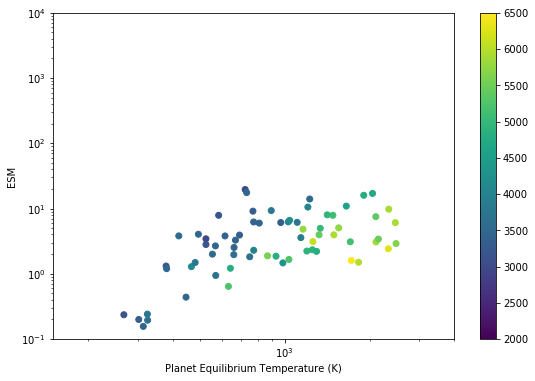

In [136]:
plt.figure(figsize=(9, 6))
m = df.loc[:, "Planet Radius Value"] < 1.7
plt.scatter(
    df.loc[m, "Planet Equilibrium Temperature (K) Value"],
    df.loc[m, "ESM"],
    c=df.loc[m, "Effective Temperature Value"],
    vmin=2000,
    vmax=6500,
)
plt.colorbar()
plt.yscale("log")
plt.xscale("log")


plt.xlim(150, 4000)
plt.ylim(0.1, 10000)

plt.ylabel("ESM")
plt.xlabel("Planet Equilibrium Temperature (K)")

plt.savefig("ESM-TESS-candidates-planetplanets-12052019-barclay.png", dpi=200)

In [141]:
df[(df.loc[:, "Planet Radius Value"] < 1.7) & (df.loc[:, "ESM"] > 10)].sort_values(by=['ESM'], ascending=False)

,TIC,Full TOI ID,TOI Disposition,TIC Right Ascension,TIC Declination,TMag Value,Orbital Epoch Value,Orbital Period Value,Transit Duration Value,Transit Depth Value,...,Star Radius Value,Planet Radius Value,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Stellar Flux Value,Signal-to-noise,rprs,tempratio,Kmag,ESM
14,410153553,136.01,PC,340.492100,-69.169000,11.87700,1325.726030,0.462910,0.520794,4681.643995,...,0.179000,1.267697,723.126924,3043.0,64.621812,0.817114,0.064856,0.073228,9.145,19.590018
90,307210830,175.01,PC,124.531900,-68.313000,9.39300,1356.203945,3.690604,1.273675,1848.855089,...,0.313000,1.404443,732.000000,3469.0,47.715200,29.476826,0.041091,0.063733,7.101,17.543281
828,447283466,1028.01,PC,157.098130,-51.705257,7.83200,1544.480660,1.016060,2.843000,400.000000,...,0.660000,1.036660,2048.000000,4691.0,2923.570000,13.000000,0.014384,0.358192,6.354,17.042384
435,31374837,431.02,PC,83.269151,-26.724584,8.11300,1438.379781,0.490058,1.093198,312.518541,...,0.802493,1.419494,1906.205997,4771.0,3120.328573,24.186544,0.016199,0.313675,6.723,15.969608
744,34068865,731.01,PC,146.124300,-45.776500,8.01100,1543.492309,0.321941,0.630316,242.211365,...,0.459000,0.746412,1225.463234,3518.0,532.993788,12.487692,0.014892,0.210754,5.780,14.000302
467,134200185,500.01,PC,106.558238,-47.587196,9.32492,1491.961850,0.548213,1.077637,230.896794,...,0.784845,1.582659,1652.538397,4590.0,1762.492340,7.856921,0.018467,0.260284,7.715,10.906490
1043,359496368,1178.01,PC,279.099635,55.391965,10.13600,1685.178550,2.665900,3.507000,589.288000,...,0.500000,1.342770,1207.000000,4043.4,353.396000,12.000000,0.024593,0.171210,8.125,10.534731


In [146]:
df[df.loc[:, 'Full TOI ID'] == 700.03]

,TIC,Full TOI ID,TOI Disposition,TIC Right Ascension,TIC Declination,TMag Value,Orbital Epoch Value,Orbital Period Value,Transit Duration Value,Transit Depth Value,...,Star Radius Value,Planet Radius Value,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Stellar Flux Value,Signal-to-noise,rprs,tempratio,Kmag,ESM
757,150428135,700.03,PC,97.096855,-65.579306,10.875,1331.35924,9.976745,1.973866,597.61823,...,1.0,2.452109,510.050748,3482.0,15.994643,8.204835,0.022456,0.019248,8.634,0.781087


In [148]:
df.sort_values(by=['ESM'], ascending=False).to_csv('TESS_TOIs_12052019.csv')

In [3]:
import lightkurve as lk

In [4]:
tpf = lk.search_tesscut("30.26948 +24.50990", ).download(cutout_size=(50, 50))

In [5]:
tpf.interact()

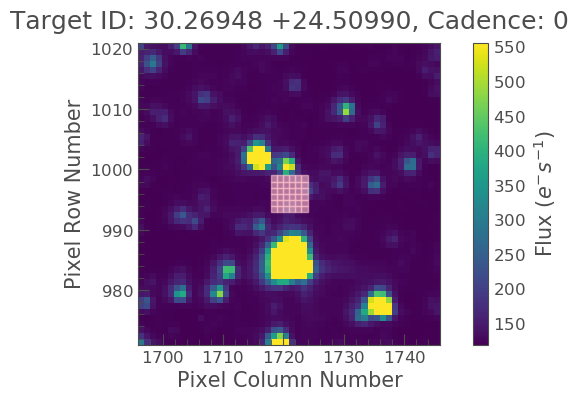

In [6]:
aper = tpf.create_threshold_mask()
aper[:,:] = False

aper[22:28, 22:28] = True

tpf.plot(aperture_mask=aper);


In [26]:
raw_lc = tpf.to_lightcurve(aperture_mask=aper)

# Make a design matrix and pass it to a linear regression corrector
dm = lk.DesignMatrix(tpf.flux[:, ~aper], name='regressors').pca(5).append_constant()
rc = lk.RegressionCorrector(raw_lc)
corrected_lc = rc.correct(dm)

# Optional: Remove the scattered light, allowing for the large offset from scattered light
corrected_lc = raw_lc - rc.model_lc + np.percentile(rc.model_lc.flux, 5)


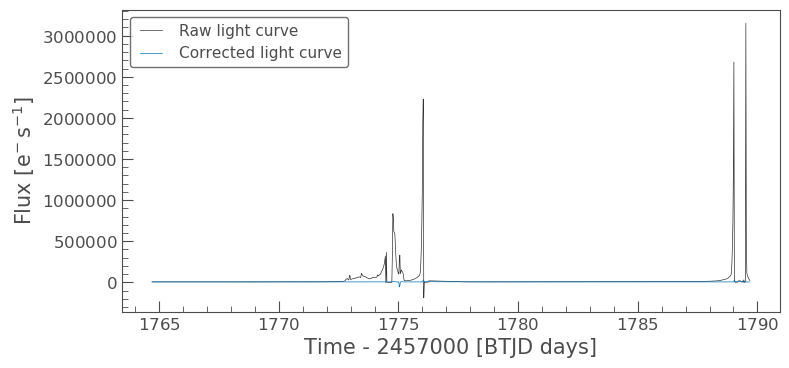

In [28]:
ax = raw_lc.plot(label='Raw light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

(4500, 5000)

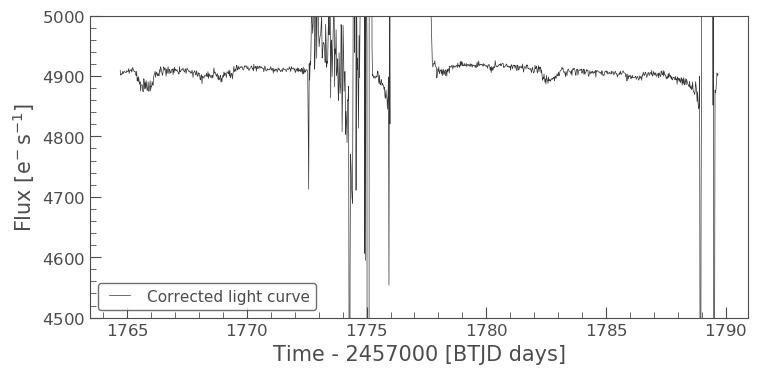

In [36]:
ax = corrected_lc.plot(label='Corrected light curve')

ax.set_ylim(4500, 5000)

/Users/tsbarcl2/anaconda3/lib/python3.7/site-packages/lightkurve-1.5.2-py3.7.egg/lightkurve/correctors/designmatrix.py:248: LightkurveWarning: The design matrix has low rank (1126) compared to the number of columns (2465), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  LightkurveWarning)


In [82]:
lcf = lk.search_lightcurvefile("TIC 206502540", ).download()

lc = lcf.get_lightcurve('PDCSAP_FLUX').normalize()

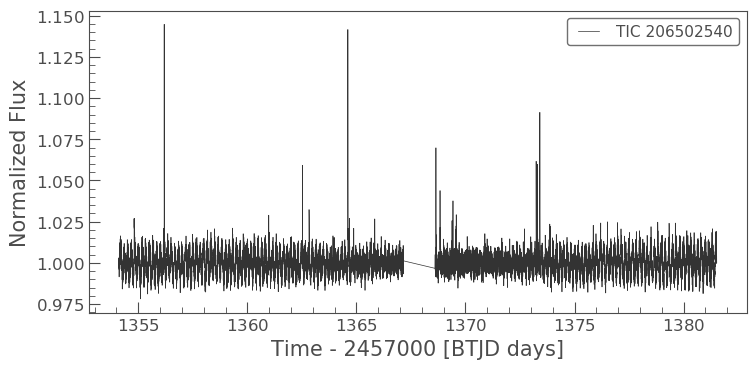

In [84]:
lc.plot()

import exoplanet as xo
m = np.isfinite(lc.time) * np.isfinite(lc.flux)
x = lc.time[m]
y = lc.flux[m]

Text(0, 0.5, 'power')

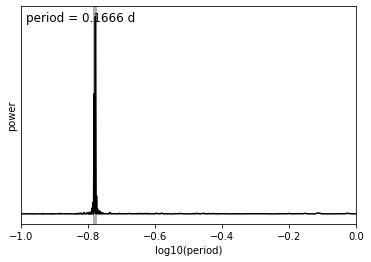

In [102]:


results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=2, min_period=0.1, max_period=1.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power")

# plt.ylim(0, 0.0000002)
# plt.xlim(-0.8,-0.76)

(1360, 1368)

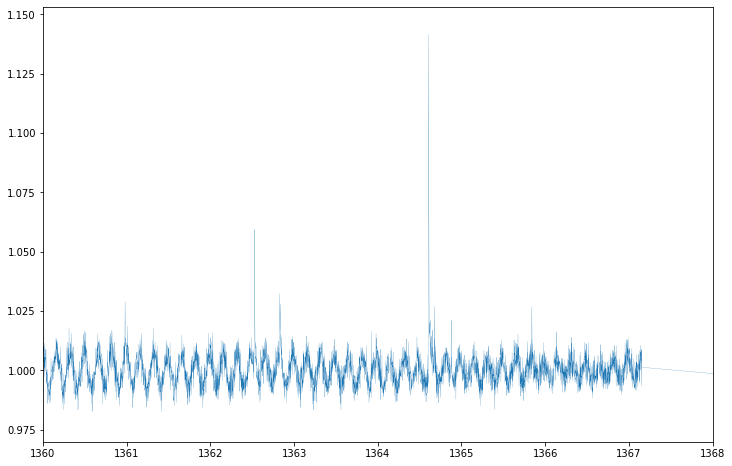

In [103]:
plt.figure(figsize=[12, 8])
plt.plot(x, y, lw=0.2)

plt.xlim(1360, 1368)

In [112]:
lcf = lk.search_lightcurvefile("341.7072132253419 +44.3339922842305", mission='TESS').download()

lc = lcf.get_lightcurve('PDCSAP_FLUX').normalize()

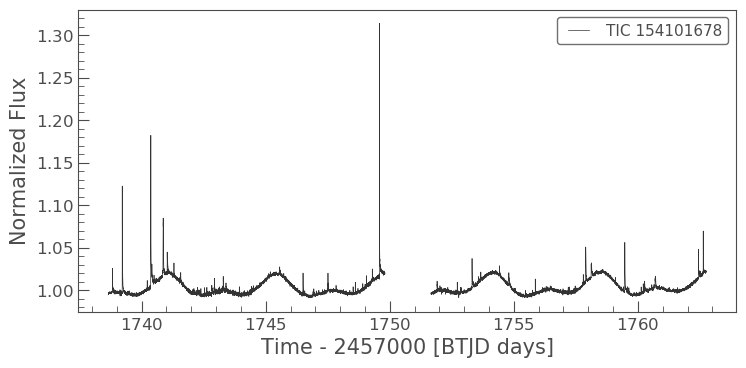

In [113]:
lc.plot()

import exoplanet as xo
m = np.isfinite(lc.time) * np.isfinite(lc.flux)
x = lc.time[m]
y = lc.flux[m]

Text(0, 0.5, 'power')

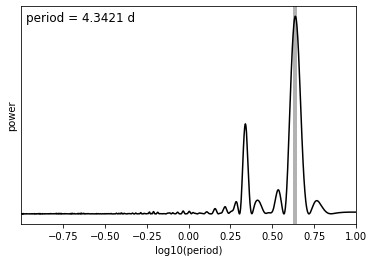

In [115]:

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=2, min_period=0.1, max_period=10.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power")



In [118]:
lk.search_tesscut('WRAY 15-1269').download(cutout_size=(50, 50))

/Users/tsbarcl2/anaconda3/lib/python3.7/site-packages/lightkurve-1.5.2-py3.7.egg/lightkurve/search.py:233: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


TessTargetPixelFile(TICID: WRAY 15-1269)